# Import Packages

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Generate Noisy Training Data
- We will build a neural net (nn) to fit a quadratic function.
- We will first generate some noisy training data to simulate real-world data.
- NNs are noise-resistant.

In [2]:
# Generate synthetic data
np.random.seed(42) # For reproducibility
x = np.linspace(-10, 10, 100000)
a, b, c = 2, 3, -1 # True parameters. We will try to recover these parameters
# True model + noise.
y = a * x ** 2 + b * x + c + np.random.normal(0, 1, len(x))

print(x.shape, y.shape)

(100000,) (100000,)


# Build Dataset and DataLoader

In [3]:
class MyDataset(Dataset):
    def __init__(self, x, y):
        self.x = np.vstack((x ** 2, x)).T  # Create new features (x^2 and x)
        self.y = y

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

# split train, val, test
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.4, random_state=42)


train_dataset = MyDataset(x_train, y_train)
val_dataset = MyDataset(x_val, y_val)
test_dataset = MyDataset(x_test, y_test)

# Implement the gradient descent optimizer:

In [4]:
# Compute loss
def compute_loss(X, y, weights):
    predictions = X @ weights
    errors = predictions - y
    return np.mean(errors ** 2) / 2

# Compute gradients
def compute_gradients(X, y, weights):
    predictions = X @ weights
    errors = predictions - y
    gradients = X.T @ errors / len(y)
    return gradients

# Feature scaling with epsilon to avoid division by zero
def scale_features(X):
    means = np.mean(X, axis=0)
    stds = np.std(X, axis=0)
    epsilon = 1e-8  # Small value to ensure we don't divide by zero
    return (X - means) / (stds + epsilon)

# Full batch gradient descent with feature scaling
def full_batch_gradient_descent(X, y, learning_rate=0.001, n_iterations=100000, tolerance=1e-12):
    # Feature scaling
    X_scaled = scale_features(X)
    # Adding a column of ones to account for the bias term (intercept)
    X_scaled = np.hstack([np.ones((X_scaled.shape[0], 1)), X_scaled])

    weights = np.zeros(X_scaled.shape[1])
    loss_history = []
    previous_loss = float('inf')

    for i in range(n_iterations):
        gradients = compute_gradients(X_scaled, y, weights)
        weights -= learning_rate * gradients
        loss = compute_loss(X_scaled, y, weights)
        loss_history.append(loss)

        # Convergence check
        if abs(previous_loss - loss) < tolerance:
            print(f'Convergence reached at iteration {i}.')
            break
        previous_loss = loss

        if i % 10000 == 0:  # More frequent updates to track progress
            print(f'[Full batch] Iteration {i}, loss: {loss}')

    return weights, loss_history

# Stochastic gradient descent with feature scaling
def stochastic_gradient_descent(X, y, learning_rate=0.001, n_iterations=100000, batch_size=1):
    # Feature scaling
    X_scaled = scale_features(X)
    # Adding a column of ones to account for the bias term (intercept)
    X_scaled = np.hstack([np.ones((X_scaled.shape[0], 1)), X_scaled])

    weights = np.zeros(X_scaled.shape[1])
    loss_history = []
    n_samples = len(y)

    for i in range(n_iterations):
        indices = np.random.choice(n_samples, batch_size, replace=False)
        X_batch = X_scaled[indices]
        y_batch = y[indices]
        gradients = compute_gradients(X_batch, y_batch, weights)
        weights -= learning_rate * gradients
        loss = compute_loss(X_scaled, y, weights)
        loss_history.append(loss)

        if i % 10000 == 0:  # More frequent updates to track progress
            print(f'[SGD] Iteration {i}, loss: {loss}')

    return weights, loss_history

# Perform Training

[Full batch] Iteration 0, loss: 4087.2834080051853


[Full batch] Iteration 10000, loss: 554.5026856418671
[Full batch] Iteration 20000, loss: 75.60140590748021
[Full batch] Iteration 30000, loss: 10.680606938994925
[Full batch] Iteration 40000, loss: 1.8796429001980017
[Full batch] Iteration 50000, loss: 0.6865200635188596
[Full batch] Iteration 60000, loss: 0.5247684652269512
[Full batch] Iteration 70000, loss: 0.5028393806431097
[Full batch] Iteration 80000, loss: 0.4998663395415588
[Full batch] Iteration 90000, loss: 0.4994632608861053
[SGD] Iteration 0, loss: 4087.2916877282796
[SGD] Iteration 10000, loss: 554.2937389345827
[SGD] Iteration 20000, loss: 75.73075917404002
[SGD] Iteration 30000, loss: 10.711523774636618
[SGD] Iteration 40000, loss: 1.8806955899171123
[SGD] Iteration 50000, loss: 0.6874217468164718
[SGD] Iteration 60000, loss: 0.5248090352426592
[SGD] Iteration 70000, loss: 0.5029056481409991
[SGD] Iteration 80000, loss: 0.49986228593576426
[SGD] Iteration 90000, loss: 0.49947489547769697


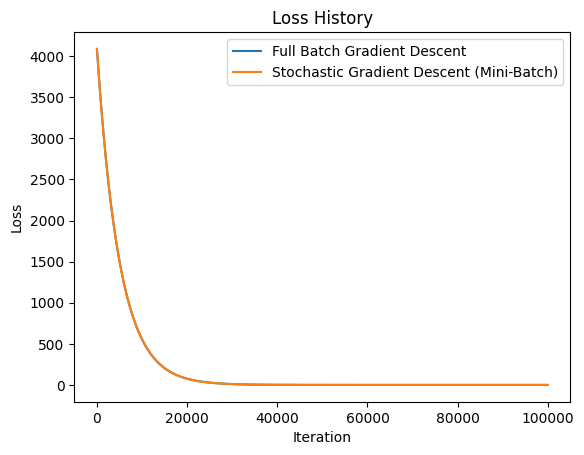

In [5]:
# Add a column of ones to the feature set to account for the bias term
x_train_with_bias = np.hstack((np.ones((len(train_dataset), 1)), train_dataset[:][0]))
x_val_with_bias = np.hstack((np.ones((len(val_dataset), 1)), val_dataset[:][0]))
x_test_with_bias = np.hstack((np.ones((len(test_dataset), 1)), test_dataset[:][0]))

# Perform full-batch gradient descent
weights_full_batch, loss_history_full_batch = full_batch_gradient_descent(x_train_with_bias, y_train, learning_rate=0.0001, n_iterations=100000)

# Perform stochastic gradient descent with mini-batches
weights_sgd, loss_history_sgd = stochastic_gradient_descent(x_train_with_bias, y_train, learning_rate=0.0001, n_iterations=100000, batch_size=128)

# Plot the loss history for comparison
plt.plot(loss_history_full_batch, label='Full Batch Gradient Descent')
plt.plot(loss_history_sgd, label='Stochastic Gradient Descent (Mini-Batch)')
plt.title('Loss History')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Predictions and Evaluation

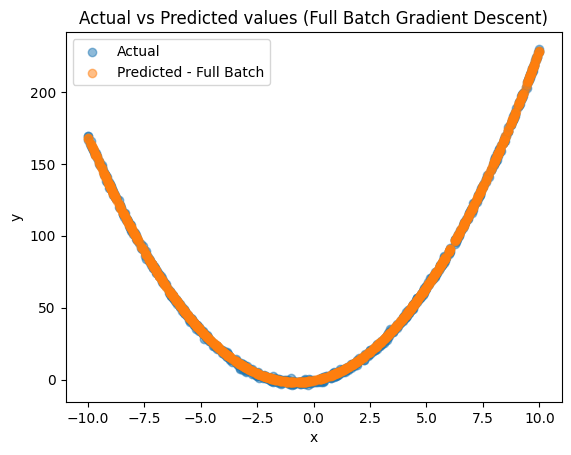

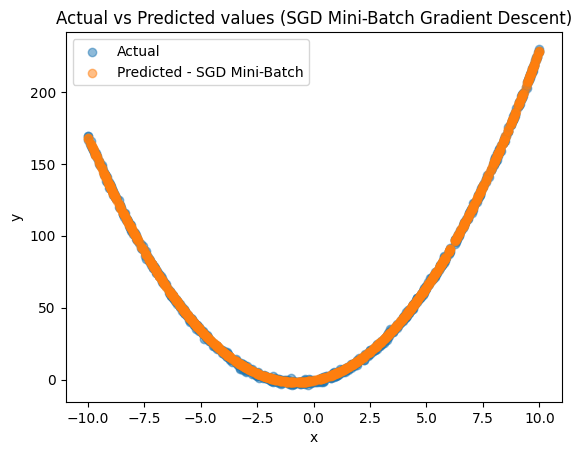

MSE (Full Batch): 1.099047760069497
MSE (SGD Mini-Batch): 1.0983773838353958


In [8]:
# Function to predict values using learned weights
def predict(X, weights):
    X = scale_features(X)
    X = np.hstack([np.ones((X.shape[0], 1)), X])
    return X @ weights

# Function to calculate the mean squared error
def calculate_mse(y_true, y_pred):
    return np.mean((y_true - y_pred) ** 2)

# Predict values on the validation set
y_pred_full_batch = predict(x_val_with_bias, weights_full_batch)
y_pred_sgd = predict(x_val_with_bias, weights_sgd)

# Visualize the fitting results for full-batch gradient descent
plt.scatter(x_val[:1000], y_val[:1000], alpha=0.5, label='Actual')
plt.scatter(x_val[:1000], y_pred_full_batch[:1000], alpha=0.5, label='Predicted - Full Batch')
plt.title('Actual vs Predicted values (Full Batch Gradient Descent)')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()

# Visualize the fitting results for stochastic gradient descent (mini-batch)
plt.scatter(x_val[:1000], y_val[:1000], alpha=0.5, label='Actual')
plt.scatter(x_val[:1000], y_pred_sgd[:1000], alpha=0.5, label='Predicted - SGD Mini-Batch')
plt.title('Actual vs Predicted values (SGD Mini-Batch Gradient Descent)')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()

# Compare the weights learned from both methods with the true parameters
print(f"MSE (Full Batch): {calculate_mse(y_val, y_pred_full_batch)}")
print(f"MSE (SGD Mini-Batch): {calculate_mse(y_val, y_pred_sgd)}")